***
# Applied Data Science Capstone Project 
***

#### <i>Applied Data Science Capstone Project</i> by IBM 

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Description](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

***
<a id='introduction'></a>
## Introduction: Business Problem 
***

Comparing property rental prices of various suburbs in **Cape Town, South Africa** with indicators such as the amount of bedrooms and bathrooms to identify which indicators play a significant role in determining the rental price for these areas. The suburbs are analysed to illustrate which areas are most and least expensive using folium for visualisation.

The target stakeholders for this project are people looking to rent a 2 bedroom property in Cape Town and aren't sure which suburbs will meet their budget.

### Background
***


It is difficult to define an average property rental price for a specific suburb without analysing various properties within that suburb. Various indicators are expected to also play a role in distinguishing site specific rental prices. Being able to analyse these indicators and correlating them with real data will allow for a better understanding of the true value of specific sites within a region, according to available market data. This data could be used to identify a property that is optimally located and priced according to specific personal preference.


***
<a id='data'></a>
## Data Description
***

#### Suburb Data

Suburb data for all the suburbs in **Cape Town** will be extracted from: https://www.privateproperty.co.za/to-rent/western-cape/cape-town/55

This data will be used to group various suburbs in larger regions within the Cape Town area, using the specified alocators located in the list above. This data provides the structure for all the investigated regions.


#### Rental Data


Property rental data will be scraped from PrivateProperty: https://www.privateproperty.co.za/ for each area. The filter criteria will be set to only search for property categories: **Houses, Flats & Apartment and Townhouses & Clusters**.

This data will be used to derive a region specific average rental price as well as identifying price ranges within specific regions. This data will be merged with the area/suburb data.


#### Foursquare Indicators

The Foursquare API will be implemented to extract geographical data to identify which types of facilities are in the various areas.

### Data Collection

This project focuses on rental price data therefore requiring a large amount of data to be scraped from the PrivateProperty platform. This process is executed scraping suburb data and corresponding rental listings available on the platform. Geological data is also required for each suburb which is derived through using a geocoder and Google Maps.

### Imports
***

In [184]:
# Import required libraries for project
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import folium 
import requests 
import bs4
import time
import json

from pandas.io.json import json_normalize
from sklearn import preprocessing
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim 

print('Libraries imported.')

Libraries imported.


### Scraping the privateproperty page for areas and suburb names
***

The rental property listings are considered to be groupable by area and suburb. The area data and suburb data can be scraped from the Cape Town info page through the use of BeautifulSoup.

In [3]:
# Get data and beautifulsoup object for areas and suburb page on privateproperty
data_sub = requests.get('https://www.privateproperty.co.za/to-rent/western-cape/cape-town/55').text
soup_sub = BeautifulSoup(data_sub,'lxml')

# Get beautifulsoup areas and suburbs container elements
areas = soup_sub.find("div", {"id": "areas"}).find_all("a")
suburbs = soup_sub.find("div", {"id": "mainSuburbs"}).find_all("a")

# Define scraping area list and string list of areas
area_links = ["https://www.privateproperty.co.za" +  areas[i].get('href') + "?pt=5,2,10&page=1" for i in range(len(areas))]
area_list  = [area.string[1:] for area in areas]

In [4]:
# Define area and suburb dataframe
df_area_sub = pd.DataFrame(columns=["area", "suburb"])

# Iterate through areas in area_links list
for area in area_links:
    
    # Get specific area data and beautifulsoup object
    area_data = requests.get(area).text
    area_soup = BeautifulSoup(area_data,'lxml')
    
    # Extract area suburbs containeer and store specific area in "spec_area"
    area_subs = area_soup.find("div", {"id": "suburbsInAreaLinksContainer"})
    spec_area = area_list[area_links.index(area)]
    
    # Iterate through area suburbs 
    for sub in area_subs:
        
        # Ignore invalid "\n" entries
        if len(sub.string) < 4:
            continue
            
        # Store suburb string in variable
        suburb = sub.string
        
        # Append suburbs and it's specific area to "df_area_sub"
        df_area_sub = df_area_sub.append({"area": spec_area, "suburb": suburb}, ignore_index = True)

In [5]:
df_area_sub.head()

,area,suburb
0,Atlantic Seaboard,Sea Point
1,Atlantic Seaboard,Camps Bay
2,Atlantic Seaboard,Waterfront
3,Atlantic Seaboard,Fresnaye
4,Atlantic Seaboard,Three Anchor Bay


#### Identify suburb count per area

In [175]:
df_area_sub.value_counts("area")

area
Durbanville               27
Southern Suburbs          26
Bellville                 25
Kuilsriver                20
Milnerton                 16
Peninsula (False Bay)     15
Parow                     15
Cape Flats                15
Cape Town City Bowl       13
Atlantic Seaboard         12
Tableview and Blouberg    11
Brackenfell               10
Goodwood                   9
Kraaifontein               9
Melkbosstrand              4
Matroosfontein             3
Hout Bay                   3
Buh-Rein                   2
dtype: int64

It can be seen that the various areas vary significantly in size as Durbanville has 27 different suburbs while Buh-Rein only has 2. This will influence the data distribution between various area therefore suggesting that suburbs be evaluated individually.

### Scaping property rental prices and suburb names
***

The property data that needs to be compiled included the property's suburb, price, amount of bedrooms, amount of bathrooms and the notes that would indicate whether the property is rentable on a monthly or a "per day" bassis. Datapoints containing the "per day" tag will later be removed as these datapoints do not fall within the scope of this project.

In [7]:
# Define property rentals dataframe
df_rentals = pd.DataFrame(columns=["suburb", "price", "beds", "baths", "notes"])

# Start time
t0 = time.time()

# Iterate through various area links
for link in area_links:

    # Create beautifulsoup object for first page
    scrape_data = requests.get(link).text
    scrape_soup = BeautifulSoup(scrape_data, 'lxml')
    
    # Scrape amount of listings for the area
    listings = int(scrape_soup.find("div", {"class": "listingCount"}).string[scrape_soup.find("div", {"class": "listingCount"}).string.find("of", 5)+3:scrape_soup.find("div", {"class": "listingCount"}).string.find("\r\n", 5)])

    # Define amount of pages to scrape
    if listings <= 24:
        pages = 1
    elif listings <= 48:
        pages = 2
    else:
        pages = int(scrape_soup.find_all("a", {"class": "pageNumber"})[-2].string)+1

    for i in range(1,pages+1):

        # Create looping link
        nextlink = link[:-1] + str(i)

        # Create beautifulsoup object for first page
        scrape_data = requests.get(nextlink).text
        scrape_soup = BeautifulSoup(scrape_data, 'lxml')

        try:
            # Scrape property suburb, price, amount of bedrooms and bathrooms and notes used to filter results
            subs_hold = scrape_soup.find("div", {"class": "resultsItemsContainer"}).find_all("div", {"class": "suburb"})
            prices_hold = scrape_soup.find("div", {"class": "resultsItemsContainer"}).find_all("div", {"class": "priceDescription"})
            #bedrooms_hold = scrape_soup.find("div", {"class": "resultsItemsContainer"}).find_all("div", {"class": "title"})
            add_descriptor_hold = scrape_soup.find("div", {"class": "resultsItemsContainer"}).find_all("div", {"class": "priceAdditionalDescriptor"})
            features_hold = scrape_soup.find("div", {"class": "resultsItemsContainer"}).find_all("div", {"class": "features row"})
        except:
            continue

        # Remove unwanted string context
        subs = [sub.string for sub in subs_hold]
        prices = [float(price.string.replace("R", "").replace(" ", "")) for price in prices_hold]
        #bedrooms = [bed.string[0:(bed.string.index("in")-1)] for bed in bedrooms_hold if bed.string!=None]
        add_descriptor = [add.string for add in add_descriptor_hold]
        beds, baths = [], []
        
        # Confirm whether bedroom and bathroom tags are pressent
        for feature in features_hold:
            if isinstance(feature.find("div", {"class": "icon bedroom"}), bs4.element.Tag) and isinstance(feature.find("div", {"class": "icon bathroom"}), bs4.element.Tag):
                beds.append(float(feature.find("div", {"class": "number"}).string))
                baths.append(float(feature.find_all("div", {"class": "number"})[1].string))
            else:
                beds.append(np.nan)
                baths.append(np.nan)
        
        # Construct dataframe with all scraped data
        for suburb, price, note, bed, bath in zip(subs, prices, add_descriptor, beds, baths):
            df_rentals = df_rentals.append({"suburb": suburb, "price": price, "notes": note, "beds": bed, "baths": bath}, ignore_index = True)

# End time
t1 = time.time()

print(f"{t1-t0} seconds to complete.")

422.5272433757782 seconds to complete.


In [8]:
df_rentals.head()

,suburb,price,beds,baths,notes
0,Waterfront,40000.0,2.0,2.0,None
1,Sea Point,19500.0,4.0,2.0,None
2,Llandudno,59000.0,5.0,4.5,DEP R 59K
3,Mouille Point,12500.0,2.0,1.0,None
4,Green Point,2000.0,2.0,2.0,PER DAY


In [176]:
df_rentals['notes'].value_counts()

PER DAY         419
DEP R 15K        94
DEP R 12K        77
DEP R 18K        65
DEP R 11.25K     58
               ... 
DEP R 31.9K       1
DEP R 31.5K       1
DEP R 10.49K      1
DEP R 29.6K       1
DEP R 32.5K       1
Name: notes, Length: 372, dtype: int64

From the values seen above it can be seen that various "PER DAY" entries are present in the dataframe which will be removed due to it's irrelevance.

In [10]:
df_rentals.describe(include='all')

,suburb,price,beds,baths,notes
count,7648,7.648000e+03,7483.000000,7483.000000,2842
unique,209,NaN,NaN,NaN,372
top,Cape Town City Centre,NaN,NaN,NaN,PER DAY
freq,438,NaN,NaN,NaN,419
mean,NaN,1.639334e+04,2.154443,1.656969,NaN
std,NaN,6.337204e+04,1.189928,1.136464,NaN
min,NaN,5.000000e+02,0.100000,1.000000,NaN
25%,NaN,7.500000e+03,1.000000,1.000000,NaN
50%,NaN,1.000000e+04,2.000000,1.000000,NaN
75%,NaN,1.500000e+04,3.000000,2.000000,NaN


##### **Clean df_rentals to remove unusable data and reset index**

All datapoints within the dataset that aren't within the scope of this project are removed in the cleaning process.

In [12]:
# Drop values that are out of range [0.5 - 5.0] and priced "PER DAY"
df_rentals_clean = df_rentals.drop(df_rentals[(df_rentals['notes'] == "PER DAY") | (df_rentals['beds'] < 0.5) | (df_rentals['beds'] > 5.0)].index)

# Drop entries containing NaN values
df_rentals_clean.dropna(inplace=True)
df_rentals_clean.reset_index(drop=True, inplace=True)

df_rentals_clean.head(10)

,suburb,price,beds,baths,notes
0,Llandudno,59000.0,5.0,4.5,DEP R 59K
1,Sea Point,8900.0,1.0,1.0,DEP R 8.9K
2,Sea Point,13800.0,1.0,2.0,DEP R 27.6K
3,Three Anchor Bay,21950.0,2.0,1.0,DEP R 21.95K
4,Green Point,11500.0,1.0,1.0,DEP R 18.75K
5,Sea Point,14000.0,2.0,1.0,DEP R 28K
6,Green Point,26900.0,2.0,2.0,DEP R 26.9K
7,Green Point,44500.0,3.0,3.0,DEP R 89K
8,Fresnaye,10000.0,1.0,1.0,DEP R 20K
9,Sea Point,10000.0,1.0,1.0,DEP R 20K


In [13]:
df_rentals_clean.shape

(2358, 5)

In [14]:
df_rentals_clean.describe(include='all')

,suburb,price,beds,baths,notes
count,2358,2.358000e+03,2358.000000,2358.000000,2358
unique,181,NaN,NaN,NaN,362
top,Sea Point,NaN,NaN,NaN,DEP R 15K
freq,126,NaN,NaN,NaN,93
mean,NaN,1.446767e+04,1.983461,1.459712,NaN
std,NaN,5.054713e+04,0.864089,0.722589,NaN
min,NaN,1.000000e+03,0.500000,1.000000,NaN
25%,NaN,7.700000e+03,1.000000,1.000000,NaN
50%,NaN,1.000000e+04,2.000000,1.000000,NaN
75%,NaN,1.400000e+04,2.000000,2.000000,NaN


### Obtain location data for suburbs using geocoder
***

###### **Code used to extract location data using geocoder.**

df_locations = pd.DataFrame(columns=["suburb", "latitude", "longitude"])

for area, sub in zip(list(df_area_sub['area']), list(df_area_sub['suburb'])):
    
    address = sub + ', Cape Town, South Africa'
    
    try:
        geolocator = Nominatim(user_agent="location_agent")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:

        latitude = np.nan
        longitude = np.nan
    
    df_locations = df_locations.append({"suburb": sub, "latitude": latitude, "longitude": longitude}, ignore_index = True)

df_locations.to_excel("Locations.xlsx")

#### Comment

The Nominatim geocoder was unable to identify all the suburbs. The  suburbs' locations that were unidentified were obtained manually through Google Maps.

#### Import created excel sheet with completed location data as DataFrame

In [15]:
df_locations = pd.read_excel('Locations.xlsx')
df_locations.head()

,suburb,latitude,longitude
0,Sea Point,-33.917222,18.392222
1,Camps Bay,-33.954774,18.381852
2,Waterfront,-33.903056,18.421667
3,Fresnaye,-33.925194,18.387743
4,Three Anchor Bay,-33.909167,18.395556


#### Merge suburb/area data with location [longitude,latitude] data

In [16]:
df_sub_data = pd.merge(df_area_sub, df_locations, on="suburb")
df_sub_data.head()

,area,suburb,latitude,longitude
0,Atlantic Seaboard,Sea Point,-33.917222,18.392222
1,Atlantic Seaboard,Camps Bay,-33.954774,18.381852
2,Atlantic Seaboard,Waterfront,-33.903056,18.421667
3,Atlantic Seaboard,Fresnaye,-33.925194,18.387743
4,Atlantic Seaboard,Three Anchor Bay,-33.909167,18.395556


### Using FourSquare API to obtain significant suburb location data
***

##### FourSquare Credentials

In [17]:
CLIENT_ID = '4CVGFP4Q4EHIDKDP2KCFP1N1LAWHYHTVHLLEBFF3KWQFKEOS' # your Foursquare ID
CLIENT_SECRET = 'TGQFGPZPJI2IDYBHH3OEQOUC5ZFISUTZANOKFA4DQH20GYJ3' # your Foursquare Secret
ACCESS_TOKEN = 'DE4XBVC3WT3ITVKY4VHACN2FGOOS4OFV55LMI23QBQDVAKXE' # your FourSquare Access Token
VERSION = '20180604'
RADIUS = 2000
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4CVGFP4Q4EHIDKDP2KCFP1N1LAWHYHTVHLLEBFF3KWQFKEOS
CLIENT_SECRET:TGQFGPZPJI2IDYBHH3OEQOUC5ZFISUTZANOKFA4DQH20GYJ3


##### Define function for obtaining FourSquare data

In [18]:
def get_json_data(latitude, longitude):
    
    # Define API uri
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, RADIUS, LIMIT)

    # get data from API request
    results = requests.get(url).json()
    
    return results['response']['groups'][0]['items']

##### Get relevant location information from JSON object

In [19]:
def get_location_info(json):

    df_items = pd.json_normalize(json) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.distance', 'venue.id']
    df_filtered = df_items.loc[:, filtered_columns]

    # filter the category for each row
    df_filtered['venue.categories'] = [df_items["venue.categories"][i][0]["name"] for i in range(len(df_items["venue.categories"]))]

    # clean columns
    df_filtered.columns = [col.split('.')[-1] for col in df_filtered.columns]
    
    return df_filtered

##### Obtain suburb exploratory data from FourSquare

In [20]:
df_site_info = pd.DataFrame([[sub, get_location_info(get_json_data(lat, lng))] for sub, lat, lng in zip(df_sub_data['suburb'], df_sub_data['latitude'], df_sub_data['longitude'])])

In [21]:
df_site_info.rename(columns = {0: 'suburb', 1: 'sub_data'}, inplace = True)

##### Merge suburb data with FourSquare location data

In [180]:
df_sub_data = pd.merge(df_sub_data, df_site_info, on='suburb')
df_sub_data.head()

,area,suburb,latitude,longitude,sub_data_x,sub_data_y
0,Atlantic Seaboard,Sea Point,-33.917222,18.392222,...,...
1,Atlantic Seaboard,Camps Bay,-33.954774,18.381852,...,...
2,Atlantic Seaboard,Waterfront,-33.903056,18.421667,name cate...,name cate...
3,Atlantic Seaboard,Fresnaye,-33.925194,18.387743,...,...
4,Atlantic Seaboard,Three Anchor Bay,-33.909167,18.395556,name ...,name ...


***
<a id='methodology'></a>
## Methodology
***

The methodology that is implemented involves constructing a dataframe from the obtained data above that can be grouped by suburb and amount of bedrooms. This dataframe will be used to obtain relevant 2 bedroom apartment/house data from the available dataset. The 2 bedroom data will have prices that would need to be normalised in-order to obatin a scale for which the data can be represented on a folium map. 

***
<a id='analysis'></a>
## Analysis
***

##### Construct dummy variable dataframe on amount of bedrooms

In [23]:
df_dummy_hold = df_rentals_clean
df_dummy_hold["bed_count"] = df_rentals_clean["beds"]

df_rentals_dummy = pd.get_dummies(df_dummy_hold, columns=['bed_count'])
df_rentals_dummy.head()

,suburb,price,beds,baths,notes,bed_count_0.5,bed_count_1.0,bed_count_1.5,bed_count_2.0,bed_count_2.5,bed_count_3.0,bed_count_4.0,bed_count_5.0
0,Llandudno,59000.0,5.0,4.5,DEP R 59K,0,0,0,0,0,0,0,1
1,Sea Point,8900.0,1.0,1.0,DEP R 8.9K,0,1,0,0,0,0,0,0
2,Sea Point,13800.0,1.0,2.0,DEP R 27.6K,0,1,0,0,0,0,0,0
3,Three Anchor Bay,21950.0,2.0,1.0,DEP R 21.95K,0,0,0,1,0,0,0,0
4,Green Point,11500.0,1.0,1.0,DEP R 18.75K,0,1,0,0,0,0,0,0


##### Group dummy variables by suburb and amount of bedrooms to determine mean price

In [177]:
df_rental_stats = df_rentals_dummy.groupby(by=["suburb","bed_count_0.5", "bed_count_1.0", "bed_count_1.5", "bed_count_2.0", "bed_count_2.5", "bed_count_3.0", "bed_count_4.0", "bed_count_5.0"]).mean()
df_rental_stats

price  \
suburb     bed_count_0.5 bed_count_1.0 bed_count_1.5 bed_count_2.0 bed_count_2.5 bed_count_3.0 bed_count_4.0 bed_count_5.0                 
Amandelsig 0             0             0             0             0             1             0             0              15000.000000   
                         1             0             0             0             0             0             0               6900.000000   
Athlone    0             0             0             0             0             0             1             0              11862.500000   
                                                                                 1             0             0               9888.888889   
                                                     1             0             0             0             0               7287.500000   
...                                                                                                                                  ...   
Wynberg    0             1             0             0             0             0             0             0               6864.285714   
Zonnebloem 0             0             0             0             0             1             0             0              13300.000000   
                                                     1             0             0             0             0              10914.900000   
                         1             0             0             0             0             0             0               8190.000000   
           1             0             0             0             0             0             0             0               6600.000000   

                                                                                                                            beds  \
suburb     bed_count_0.5 bed_count_1.0 bed_count_1.5 bed_count_2.0 bed_count_2.5 bed_count_3.0 bed_count_4.0 bed_count_5.0         
Amandelsig 0             0             0             0             0             1             0             0               3.0   
                         1             0             0             0             0             0             0               1.0   
Athlone    0             0             0             0             0             0             1             0               4.0   
                                                                                 1             0             0               3.0   
                                                     1             0             0             0             0               2.0   
...                                                                                                                          ...   
Wynberg    0             1             0             0             0             0             0             0               1.0   
Zonnebloem 0             0             0             0             0             1             0             0               3.0   
                                                     1             0             0             0             0               2.0   
                         1             0             0             0             0             0             0               1.0   
           1             0             0             0             0             0             0             0               0.5   

                                                                                                                               baths  
suburb     bed_count_0.5 bed_count_1.0 bed_count_1.5 bed_count_2.0 bed_count_2.5 bed_count_3.0 bed_count_4.0 bed_count_5.0            
Amandelsig 0             0             0             0             0             1             0             0              2.000000  
                         1             0             0             0             0             0             0              1.000000  
Athlone    0             0             0             

The rentals stats dataframe above indicates how the average prices of a rental property increases with an increase in the amount of bedrooms.

##### Merge amount of bedrooms-price stats with suburb data

In [25]:
df_complete_data = pd.merge(df_sub_data, df_rental_stats, on='suburb')
df_complete_data.head()

,area,suburb,latitude,longitude,sub_data,price,beds,baths
0,Atlantic Seaboard,Sea Point,-33.917222,18.392222,...,45750.000000,4.0,3.750000
1,Atlantic Seaboard,Sea Point,-33.917222,18.392222,...,30979.166667,3.0,2.375000
2,Atlantic Seaboard,Sea Point,-33.917222,18.392222,...,17375.508475,2.0,1.500000
3,Atlantic Seaboard,Sea Point,-33.917222,18.392222,...,11010.975610,1.0,1.060976
4,Atlantic Seaboard,Sea Point,-33.917222,18.392222,...,7010.000000,0.5,1.000000


In [59]:
df = df_complete_data.groupby(by=["suburb", "beds"]).mean()
df

latitude  longitude         price     baths
suburb     beds                                              
Amandelsig 1.0  -33.928948  18.693300   6900.000000  1.000000
           3.0  -33.928948  18.693300  15000.000000  2.000000
Athlone    1.0  -33.966667  18.505000  18000.000000  1.000000
           2.0  -33.966667  18.505000   7287.500000  1.000000
           3.0  -33.966667  18.505000   9888.888889  1.388889
...                    ...        ...           ...       ...
Wynberg    4.0  -34.003625  18.467251  22000.000000  3.000000
Zonnebloem 0.5  -33.932546  18.435048   6600.000000  1.000000
           1.0  -33.932546  18.435048   8190.000000  1.000000
           2.0  -33.932546  18.435048  10914.900000  1.550000
           3.0  -33.932546  18.435048  13300.000000  1.000000

[477 rows x 4 columns]

##### Construct dataframe for two bedroom apartments/houses only

The scope of this project is to focus on 2 bedroom apartments. A dataframe is setup for analysing all the 2 bedroom apartments/houses.

In [178]:
df_2_bed = df_complete_data[df_complete_data['beds'] == 2.0].drop(columns = "sub_data")
df_2_bed.reset_index(inplace = True)

df_2_bed.head()

,index,area,suburb,latitude,longitude,price,beds,baths
0,2,Atlantic Seaboard,Sea Point,-33.917222,18.392222,17375.508475,2.0,1.500000
1,8,Atlantic Seaboard,Camps Bay,-33.954774,18.381852,19020.000000,2.0,1.000000
2,13,Atlantic Seaboard,Waterfront,-33.903056,18.421667,45127.777778,2.0,2.074074
3,18,Atlantic Seaboard,Three Anchor Bay,-33.909167,18.395556,15050.000000,2.0,1.437500
4,23,Atlantic Seaboard,Bantry Bay,-33.928151,18.378970,34400.000000,2.0,2.100000


The data above needs include a **normalised price** to obtain relative cost between the various suburbs. This is achieved through the use of **sci-kit learn package** using a min/max scaler.

In [182]:
x = df_2_bed[['price']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled_price = pd.DataFrame(x_scaled)

df_2_bed['scaled_price'] = df_scaled_price[0]
df_2_bed.head()

,index,area,suburb,latitude,longitude,price,beds,baths,scaled_price
0,2,Atlantic Seaboard,Sea Point,-33.917222,18.392222,17375.508475,2.0,1.500000,0.318591
1,8,Atlantic Seaboard,Camps Bay,-33.954774,18.381852,19020.000000,2.0,1.000000,0.358969
2,13,Atlantic Seaboard,Waterfront,-33.903056,18.421667,45127.777778,2.0,2.074074,1.000000
3,18,Atlantic Seaboard,Three Anchor Bay,-33.909167,18.395556,15050.000000,2.0,1.437500,0.261492
4,23,Atlantic Seaboard,Bantry Bay,-33.928151,18.378970,34400.000000,2.0,2.100000,0.736598


### Visual representation of different suburbs with 2 bedroom apartments/houses data
***

A color pallete is defined to plot various normalised prices from inexpensive (blue) to very expensive (red).

In [179]:
c_map = sns.color_palette("RdYlBu_r", as_cmap=True)

The various suburbs are plotted to a folium map and added with markers accompanied by a color coded circle to identify the cost of the specific suburb. This is done as an alternative to implementing a choropleth map which would require specific poligon data.

In [183]:
CT_map = folium.Map(location=[-33.986885169772634, 18.527222660912162], zoom_start=11, tiles="Stamen Toner")

[folium.Marker(
    location=[lat, lng],
    popup=sub,
    icon=folium.Icon(color="gray", icon="info-sign"),
).add_to(CT_map) for sub, lat, lng in zip(df_2_bed['suburb'], df_2_bed['latitude'], df_2_bed['longitude'])]

[folium.CircleMarker(
    location=[lat, lng],
    radius=20,
    popup=sub,
    color="grey",
    fill=True,
    fill_color=str(colors.to_hex(colors.to_rgb(c_map(sp)))),
).add_to(CT_map) for sub, lat, lng, sp in zip(df_2_bed['suburb'], df_2_bed['latitude'], df_2_bed['longitude'], df_2_bed['scaled_price'])]

CT_map


Text(0.5, 0, '2 bedroom apartments/houses')

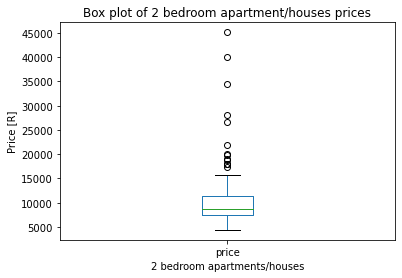

In [194]:
df_2_bed['price'].plot(kind='box')

plt.title('Box plot of 2 bedroom apartment/houses prices')
plt.ylabel("Price [R]")
plt.xlabel("2 bedroom apartments/houses")

The boxplot distribution illustrates that various datapoints are well outside of inter quartile range, therefore being defined as outliers. These outliers cause a scewed distribution that influences the effectiveness of data normalisation. The project doesn't attempt to remove these outliers as they provide significant insight into a specific area in Cape Town.

In [174]:
df_2_bed[['price','scaled_price']].describe()

,price,scaled_price
count,139.000000,139.000000
mean,10581.599594,0.151778
std,5943.388157,0.145930
min,4400.000000,0.000000
25%,7429.464286,0.074383
50%,8716.666667,0.105988
75%,11300.000000,0.169418
max,45127.777778,1.000000


***
<a id='results'></a>
## Results and Discussion
***

The data constructed and analysed in the analysis section indicates that prices for 2 bedroom rental properties **range from an average of R4 400 pm to R 45 127.78 pm** for suburbs.

From the folium map plot it can be seen that the **most expensive suburbs** are clustered in the same area included in the **Atlantic Seaboard** area. This area has prices ranging well above the 75th percentile for 2 bedroom properties in Cape Town.

Due to the nature of the normalisation and the high prices of the Atlantic Seaboard area the distribution of the data causes small variance between normalised values in similarly priced areas. It is indicated that the Atlantic Seaboard contains the subrub that has the **least expensive** rental price, namely **Athlone** [R4 400 pm] and Tableview and Blouberg the most expensive rental price, namely **Zonnebloem** [R60 000 pm].

***
<a id='conclusion'></a>
## Conclusion
***

The goal of this project was to enable an potential apartment/house seaker to identify which areas are the most and least expensive. The data that was compiled were impelemented to visually identify the areas that fall whithin the ludicrously expensive as well as the fairly inexpensive regions. The goal of this project is therefore met and could potentially be expanded to include additional indicators as well as investigate various aspects of properties and their environment that contribute towards their rental prices. Possible machine learning algorithms for identifying key visual features.